Start of 6.5 Windy Gridworld 2018-09-12 17:27:47.194828

End of Windy Gridworld 2018-09-12 17:27:47.725238
Running Time 0:00:00.530410


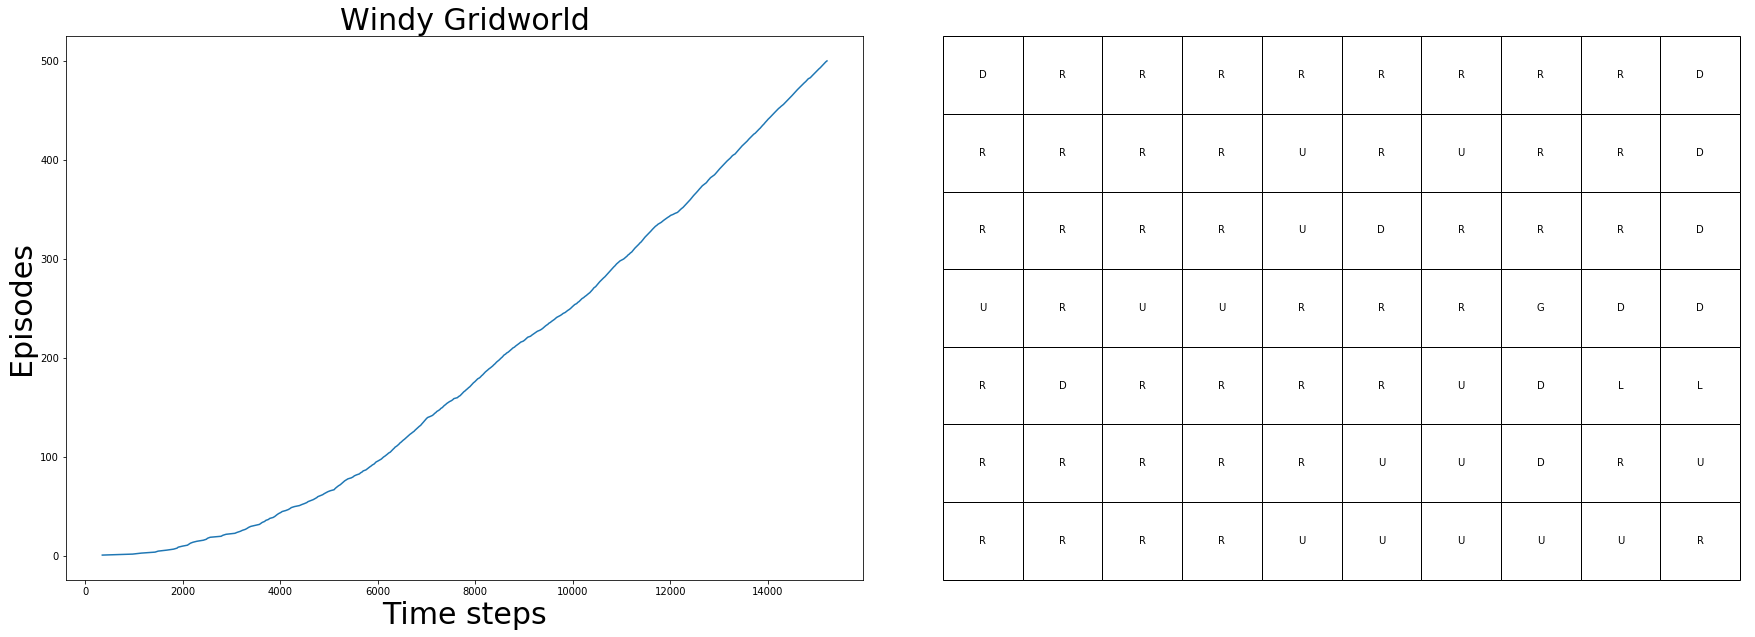

In [119]:
"""Example 6.5 Windy GridWorld
Author : SeongJin Yoon
"""
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
from matplotlib.table import Table
import random

debug_mode = False
class Action():
    up = 0
    down = 1
    left = 2
    right = 3
    
    @staticmethod
    def to_str(action):
        assert action == Action.left or action == Action.right \
            or action == Action.up or action == Action.down 
        strlist = ["up", "down", "left", "right"]
        return strlist[action]
    
    def to_char(action):
        assert action == Action.left or action == Action.right \
            or action == Action.up or action == Action.down 
        strlist = ['U', 'D', 'L', 'R']
        return strlist[action]
    
class Pos():
    
    def __init__(self, row, col):
        assert (0 <= row and row < 7) and (0 <= col and col < 10)
        self.row = row
        self.col = col
        
    def validate(self):
        if (0 <= self.row and self.row < 7) and \
            (0 <= self.col and self.col < 10) :
            return True
        return False
        
class WindyGridWorld():
    def __init__(self):
        self.GRID_HEIGHT = 7
        self.GRID_WIDTH = 10
        self.start = Pos(3,0)
        self.terminal = Pos(3,7)
        self.wind = [0, 0, 0, 1, 1, 1, 2, 2, 1, 0]
        self.discount = 1
        self.epsilon = 0.1                 
    
    def init_q_value(self):
        q_value = np.zeros((self.GRID_HEIGHT,self.GRID_WIDTH,4))
        return q_value

    def get_reward(self, state):
       return 0 if self.is_terminal(state) else -1.0
    
    def is_terminal(self, state):
        if state.row == self.terminal.row and state.col == self.terminal.col :
            return True
        return False

    def get_random_action(self, state):
        assert state.validate()

        candidate = np.ones(4)
        action = self.pick_best(candidate)
        return action

    def get_greedy_action(self, q_value, state):        
        assert state.validate()
        
        action = self.pick_best(q_value[state.row, state.col])
        return action

    def pick_best(self, candidate):
        max_list = np.argwhere(candidate[:] == np.max(candidate)).flatten()
        action = np.random.choice(max_list)
        return action
    
    def e_greedy_policy(self, q_value, state):

        if np.random.binomial(1, self.epsilon) == 1:
            action = self.get_random_action(state)
        else:
            action = self.get_greedy_action(q_value, state)
            
        return action

    def do_action(self, state, action):
        wind = self.wind[state.col]
        
        if action == Action.up:
            n_state = Pos(max(state.row- 1-wind, 0), state.col)
        elif action == Action.down:
            n_state = Pos(max(min(state.row+1-wind, self.GRID_HEIGHT - 1), 0), state.col)
        elif action == Action.left:
            n_state =  Pos(max(state.row-wind, 0), max(state.col-1, 0))
        elif action == Action.right:
            n_state =  Pos(max(state.row-wind, 0), min(state.col+1, self.GRID_WIDTH-1))

        return n_state, self.get_reward(n_state)
    
    def salsa(self, q_value, alpha):
        
        # initial state
        state = self.start
        action = self.e_greedy_policy(q_value, state)
        
        step = 0
        while self.is_terminal(state) is False:
            step += 1
            
            # One step ahead
            n_state, reward = self.do_action(state, action)
            n_action = self.e_greedy_policy(q_value, n_state)
            
            # Q value update
            error = reward + self.discount*\
                q_value[n_state.row, n_state.col, n_action]\
                - q_value[state.row, state.col, action]
                
            q_value[state.row, state.col, action] += alpha*error
            
            state = n_state
            action = n_action
            
        step += 1                
        return step
        
    def draw_salsa_plot(self):
        self.plot = Plot(nrows=1, ncols=2, figsize=(30,10))
        
        labels = ['Time steps', 'Episodes', 'Windy Gridworld']
        ax = self.plot.draw_mline_begin(labels)
        
        alpha = 0.5
        num_episode = 500
        q_value = self.init_q_value()
        steps_per_episode = []
        
        for episode_idx in range(num_episode):
            steps = self.salsa(q_value, alpha)
            steps_per_episode.append(steps)

        steps_per_episode = np.add.accumulate(steps_per_episode)
        episode_list = np.arange(1, len(steps_per_episode) + 1)
        label = ""
        self.plot.draw_mline(ax, steps_per_episode, episode_list, label)
        self.plot.draw_mline_end()
        
        self.draw_optimal_policy(q_value)
    
    def draw_optimal_policy(self, q_value):
        policy = np.full((self.GRID_HEIGHT, self.GRID_WIDTH), '')

        for row in range(self.GRID_HEIGHT):
            for col in range(self.GRID_WIDTH):
                action = np.argmax(q_value[row, col])
                policy[row, col] = Action.to_char(action)
                
        policy[self.terminal.row, self.terminal.col] = 'G'
        
        self.plot.draw_table(policy)
        
class Plot():
    def __init__(self, nrows, ncols, figsize):
        self.fig_idx = 0
        self.len_axes = nrows*ncols
        
        _, self.axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
        plt.subplots_adjust(wspace=0.1, hspace=0.2)
        if self.len_axes != 1:
            self.axes = self.axes.flatten()

    def get_axes(self, idx):
        if self.len_axes != 1: 
            ax = self.axes[self.fig_idx]
        else:
            ax = self.axes
        return ax
    
    def draw_mline_begin(self, labels):       
        ax = self.get_axes(self.fig_idx)
        
        ax.set_xlabel(labels[0], fontsize=30)
        ax.set_ylabel(labels[1], fontsize=30)
        ax.set_title(labels[2], fontsize=30)
        
        return ax
        
    def draw_mline(self, ax, pos, data, label, linestyle='solid'):
        lines = ax.plot(pos, data, label=label, linestyle=linestyle)
        
        pivot_idx = random.randint(0, (len(data)*2)//3)
        x_pos = pos[pivot_idx]
        y_pos = data[pivot_idx]
        ax.text(x_pos, y_pos, label, color = lines[0].get_color(), size=18)

    def draw_mline_end(self):       
        self.fig_idx += 1

    def draw_bar(self, pos, data, labels):
        ax = self.get_axes(self.fig_idx)
        ax.bar(pos, data)
        
        ax.set_xlabel(labels[0], fontsize=30)
        ax.set_ylabel(labels[1], fontsize=30)
        ax.set_title(labels[2], fontsize=30)
        self.fig_idx += 1
        
    def draw_table(self, data):
        ax = self.get_axes(self.fig_idx)
        ax.set_axis_off()
        tb = Table(ax, bbox=[0, 0, 1, 1])
        tb.auto_set_font_size(value=False)
        tb.set_fontsize(20)
        HEIGHT, WIDTH = data.shape
        for row in range(HEIGHT):
            for col in range(WIDTH):
                val = data[row, col]
                width, height = 1.0 / WIDTH, 1.0 / HEIGHT
                tb.add_cell(row, col, height, width,
                            text=val, loc='center', facecolor='white')

        ax.add_table(tb)
        self.fig_idx += 1
        
    def show(self):
        plt.show()
  
if __name__ == "__main__":
    begin_time = dt.datetime.now()
    print("Start of 6.5 Windy Gridworld", begin_time)
    windy_gw = WindyGridWorld()
    steps_per_episode = windy_gw.draw_salsa_plot()
    end_time = dt.datetime.now()
    print()
    print("End of Windy Gridworld", end_time)
    print("Running Time", end_time - begin_time)